<a href="https://colab.research.google.com/github/eileenthg/data-science-colabs/blob/main/data_scrape_full_code.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Data Scraping

In [ ]:
##to install scrapy package
!pip install scrapy

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 271 kB 4.8 MB/s 
     |████████████████████████████████| 57 kB 4.5 MB/s 
     |████████████████████████████████| 261 kB 43.9 MB/s 
     |████████████████████████████████| 4.0 MB 49.9 MB/s 
     |████████████████████████████████| 3.1 MB 64.8 MB/s 
     |████████████████████████████████| 93 kB 2.2 MB/s 
     |████████████████████████████████| 74 kB 3.1 MB/s 
  Created wheel for PyDispatcher: filename=PyDispatcher-2.0.6-py3-none-any.whl size=11959 sha256=a240952af8d7cab231a04f59857d071af1b3be367f84fc4631c38e1c742635ce
  Stored in directory: /root/.cache/pip/wheels/dc/b9/4a/948b1176e084b9e3f85e4ffc3d08f817b1fdf0d973bbb94f81
Successfully built PyDispatcher


In [ ]:
import scrapy #import the library
import scrapy.crawler as crawler 
from multiprocessing import Process, Queue
from twisted.internet import reactor

## Scrape with Scrapy, export raw data to data.csv

In [ ]:
# create a class to store your attributes for csv export
# https://scrapeops.io/python-scrapy-playbook/extensions/scrapy-spidermon-guide/

class ScrapeItem(scrapy.Item):
    name = scrapy.Field() # Eileen
    signature_url = scrapy.Field() # Eileen #processing: Tracy
    image_url = scrapy.Field() # Tracy #processing: Eileen
    num_of_languages = scrapy.Field() # Tracy
    nama_penuh = scrapy.Field() # Amira
    tempat_lahir = scrapy.Field() # Amira
    pendidikan = scrapy.Field() # Yanna
    pekerjaan = scrapy.Field() # Yanna

In [ ]:
# create your spider - name (the URL) and selector (part which will be extracted)  
# tutorial to follow links: https://www.mikulskibartosz.name/how-to-use-scrapy-to-follow-links-on-the-scraped-pages/
# tutorial to save to csv: https://scrapeops.io/python-scrapy-playbook/scrapy-save-csv-files
class Spider(scrapy.Spider):
    name = "wiki_biografi"
    start_urls = ['https://ms.wikipedia.org/wiki/Kategori:Biografi_dengan_tandatangan']

    custom_settings = {
        #'DEPTH_LIMIT': 1, # only go down 1 page
        'DEPTH_PRIORITY' : 1, # breadth first search
        'CONCURRENT_REQUESTS': 16,
        'DOWNLOAD_DELAY': 0.25,
        'FEEDS': {'data.csv': { 'format': 'csv', 'overwrite': True}, # export to CSV
        } 
    }

    def parse(self, response):
        
        # grab links to wikipages
        for link in response.css('div.mw-category-group a'):
          #print(output.get()) # this code will extract the text and the element tag
          yield response.follow(link, self.parse) # loop back into the spider

        # extract attributes here
        for entry in response.css('h1#firstHeading > span.mw-page-title-main'):
          if(entry):
            scrapeItem = ScrapeItem(
                name = entry.css('::text').extract_first(), # .extract_first() only gets the first attr of the element.
                signature_url = response.css('td.infobox-full-data>a.image::attr(href)').extract_first(),
                image_url = response.css('td.infobox-image>a.image::attr(href)').extract_first(), # Tracy
                num_of_languages = response.css('label#p-lang-btn-label>span.vector-menu-heading-label::text').extract_first(), # Tracy
                nama_penuh = response.css('td.infobox-data>div.nickname::text').getall(), # Amira
                tempat_lahir = response.css('td.infobox-data>div.birthplace>a::text').extract_first(), # Amira
                pendidikan = response.css('td.infobox-data>a::text').extract_first(), # Yanna
                pekerjaan = response.css('td.infobox-data.role>::text').get() or response.css('td.infobox-data.role>div::text').get() or response.css('td.infobox-data.role>div>ul>li::text').getall() # Yanna
            )
            yield scrapeItem

        # link to next page
        next_page = response.css('div#mw-pages > a::attr(href)').get()
        if (next_page):
          yield response.follow(next_page, self.parse) # loop back into the spider

In [ ]:
# the wrapper to make it run your spider
def run_spider(spider):
    def f(q):
        try:
            runner = crawler.CrawlerRunner()
            deferred = runner.crawl(spider)
            deferred.addBoth(lambda _: reactor.stop())
            reactor.run()
            q.put(None)
        except Exception as e:
            q.put(e)

    q = Queue()
    p = Process(target=f, args=(q,))
    p.start()
    result = q.get()
    p.join()

    if result is not None:
        raise result

In [ ]:
run_spider(Spider)

/usr/local/lib/python3.8/dist-packages/scrapy/utils/request.py:231: ScrapyDeprecationWarning: '2.6' is a deprecated value for the 'REQUEST_FINGERPRINTER_IMPLEMENTATION' setting.

It is also the default value. In other words, it is normal to get this warning if you have not defined a value for the 'REQUEST_FINGERPRINTER_IMPLEMENTATION' setting. This is so for backward compatibility reasons, but it will change in a future version of Scrapy.

See the documentation of the 'REQUEST_FINGERPRINTER_IMPLEMENTATION' setting for information on how to handle this deprecation.
  return cls(crawler)


# Data prepocessing

## Data processing package imports

In [ ]:
! pip install matplotlib==3.4.0
import numpy as np
import matplotlib.pyplot as plt

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


## Import data.csv into dataframe

In [ ]:
import pandas as pd

dataRaw = pd.read_csv('data.csv')
print(dataRaw.head())

                                           image_url            nama_penuh  \
0                                                NaN                   NaN   
1       /wiki/Fail:Aleksey_Leonov_ASTP_-_cropped.jpg                   NaN   
2                 /wiki/Fail:Alan_Turing_Aged_16.jpg  Alan Mathison Turing   
3  /wiki/Fail:Albert_Camus,_gagnant_de_prix_Nobel...                   NaN   
4  /wiki/Fail:Adolfo_P%C3%A9rez_Esquivel,_premio_...                   NaN   

                          name num_of_languages             pekerjaan  \
0  Biografi dengan tandatangan    Add languages                   NaN   
1                Alexei Leonov        73 bahasa  Tentera Udara Soviet   
2                  Alan Turing       149 bahasa                   NaN   
3                 Albert Camus       129 bahasa                   NaN   
4        Adolfo Pérez Esquivel        51 bahasa                   NaN   

           pendidikan                             signature_url  tempat_lahir  
0           

## Create a copy of the dataframe to store results.

In [ ]:
data = dataRaw.copy()

## General: Invalid entries

In [ ]:
data[data.duplicated(keep=False)]

,image_url,nama_penuh,name,num_of_languages,pekerjaan,pendidikan,signature_url,tempat_lahir
0,NaN,NaN,Biografi dengan tandatangan,Add languages,NaN,NaN,NaN,NaN
16,NaN,NaN,Biografi dengan tandatangan,Add languages,NaN,NaN,NaN,NaN
202,NaN,NaN,Biografi dengan tandatangan,Add languages,NaN,NaN,NaN,NaN


In [ ]:
data.drop_duplicates(keep=False, inplace=True)

## Eileen: url processing

URLs should be in the format `https://ms.wikipedia.org/wiki/Fail:(file-name)`

URLs should be unique for each page.

URLs should be able to connect to a web page which hosts a file.

###Peek at data to see how it currently looks like.

In [ ]:
data[['image_url', 'signature_url']].head()

,image_url,signature_url
1,/wiki/Fail:Aleksey_Leonov_ASTP_-_cropped.jpg,/wiki/Fail:Alexey_Leonov_signature.svg
2,/wiki/Fail:Alan_Turing_Aged_16.jpg,/wiki/Fail:Alan_Turing_signature.svg
3,"/wiki/Fail:Albert_Camus,_gagnant_de_prix_Nobel...",/wiki/Fail:Albert_Camus_signature.svg
4,"/wiki/Fail:Adolfo_P%C3%A9rez_Esquivel,_premio_...",/wiki/Fail:Firma_p%C3%A9rez_esquivel.svg
5,/wiki/Fail:Ebiet_In_Pendopo.jpg,/wiki/Fail:Signature_of_Ebiet_G_Ade.svg


### Check for null entries.

In [ ]:
temp = data[data['image_url'].isnull() | data['signature_url'].isnull()]
temp[['name', 'image_url','signature_url']]

,name,image_url,signature_url
8,A. B. Ibrahim,NaN,/wiki/Fail:A.B._Ibrahim_Signature.png
26,Georges Lemaître,NaN,/wiki/Fail:Georges_Lemaitre_signature.jpg
36,Kunto Aji,NaN,/wiki/Fail:Kunto_Aji_(signature).svg
48,Jungkook,NaN,/wiki/Fail:Signature_of_BTS%27_Jungkook.svg
97,Hank Green,/wiki/Fail:Hank_Green_by_Gage_Skidmore.jpg,NaN
107,Greta Garbo,"/wiki/Fail:Portrait_photograph_of_Greta_Garbo,...",NaN
132,Edwin Hubble,NaN,/wiki/Fail:Edwin_Hubble_signature.svg
135,Donald Trump,/wiki/Fail:Donald_Trump_official_portrait.jpg,NaN
138,Didi Petet,NaN,/wiki/Fail:Signature_of_Didi_Petet.svg
151,Davy Crockett,/wiki/Fail:David_Crockett.jpg,NaN


It is possible that the wikipedia entries simply do not have the relevant images, therefore the null entries are let alone.


### Ensure correct format

URLs should be in the format `https://ms.wikipedia.org/wiki/Fail:(file-name)`

However, currently the data is stored as `/wiki/Fail:(file-name)` (as seen during peek data)

We fix it by appending `https://ms.wikipedia.org` to the front of the urls.

Be careful not to append links to entries which do not have a url in the first place.

In [ ]:
# Convert url into usable links
data.loc[data['signature_url'].notna(), 'signature_url'] = 'https://ms.wikipedia.org' + data.loc[data['signature_url'].notna(), 'signature_url']
data.loc[data['image_url'].notna(), 'image_url'] = 'https://ms.wikipedia.org' + data.loc[data['image_url'].notna(), 'image_url']


In [ ]:
# Peek into output
data[['signature_url','image_url']].head()

,signature_url,image_url
1,https://ms.wikipedia.org/wiki/Fail:Alexey_Leon...,https://ms.wikipedia.org/wiki/Fail:Aleksey_Leo...
2,https://ms.wikipedia.org/wiki/Fail:Alan_Turing...,https://ms.wikipedia.org/wiki/Fail:Alan_Turing...
3,https://ms.wikipedia.org/wiki/Fail:Albert_Camu...,https://ms.wikipedia.org/wiki/Fail:Albert_Camu...
4,https://ms.wikipedia.org/wiki/Fail:Firma_p%C3%...,https://ms.wikipedia.org/wiki/Fail:Adolfo_P%C3...
5,https://ms.wikipedia.org/wiki/Fail:Signature_o...,https://ms.wikipedia.org/wiki/Fail:Ebiet_In_Pe...


We can now use regex to see if we get the correct format.

In [ ]:
pattern = r'https://ms.wikipedia.org/wiki/Fail:\S+'

In [ ]:
data.loc[~(data['signature_url'].notna() & data['signature_url'].str.contains(pattern)), 'signature_url']

97     NaN
107    NaN
135    NaN
151    NaN
178    NaN
206    NaN
219    NaN
225    NaN
228    NaN
269    NaN
291    NaN
318    NaN
328    NaN
334    NaN
336    NaN
348    NaN
365    NaN
Name: signature_url, dtype: object

In [ ]:
data.loc[~(data['image_url'].notna() & data['image_url'].str.contains(pattern)), 'image_url']

8      NaN
26     NaN
36     NaN
48     NaN
132    NaN
138    NaN
155    NaN
164    NaN
166    NaN
180    NaN
209    NaN
225    NaN
267    NaN
276    NaN
277    NaN
291    NaN
302    NaN
323    NaN
333    NaN
338    NaN
339    NaN
348    NaN
353    NaN
Name: image_url, dtype: object

Note that the NaN entries are wikipedia entries which do not have an image in the first place.

### Check duplicates
Each entry should have a unique image, theoretically.

In [ ]:
data.loc[(data['signature_url'].notna() & data['signature_url'].duplicated(keep=False)) | data['image_url'].notna() & data['image_url'].duplicated(keep=False)]

,image_url,nama_penuh,name,num_of_languages,pekerjaan,pendidikan,signature_url,tempat_lahir
82,https://ms.wikipedia.org/wiki/Fail:Example_ima...,NaN,Infobox person/doc,Add languages,occupation,Pengerusi,https://ms.wikipedia.org/wiki/Fail:Bill_Gates_...,"Seattle, Washington"
83,https://ms.wikipedia.org/wiki/Fail:Example_ima...,NaN,Infobox person,189 bahasa,occupation,Pengerusi,https://ms.wikipedia.org/wiki/Fail:Bill_Gates_...,"Seattle, Washington"
84,https://ms.wikipedia.org/wiki/Fail:Bill_Gates_...,NaN,Infobox Orang Terkenal/doc,Add languages,Chairman,Chairman,https://ms.wikipedia.org/wiki/Fail:Bill_Gates_...,"Seattle, Washington"
85,https://ms.wikipedia.org/wiki/Fail:Bill_Gates_...,NaN,Infobox Orang Terkenal,9 bahasa,Chairman,Chairman,https://ms.wikipedia.org/wiki/Fail:Bill_Gates_...,"Seattle, Washington"
113,https://ms.wikipedia.org/wiki/Fail:Bill_Gates_...,William Henry Gates III,Bill Gates,162 bahasa,"Pembangun perisian,pelabur,usahawan,dermawan",Universiti Harvard,https://ms.wikipedia.org/wiki/Fail:Bill_Gates_...,Seattle


It seems template pages were included into the dataset. These template pages are dropped.

In [ ]:
data.drop([82, 83, 84, 85], inplace=True)

Running the code again to ensure there are no other duplicates.

In [ ]:
data.loc[(data['signature_url'].notna() & data['signature_url'].duplicated(keep=False)) | data['image_url'].notna() & data['image_url'].duplicated(keep=False)]

,image_url,nama_penuh,name,num_of_languages,pekerjaan,pendidikan,signature_url,tempat_lahir


### Ensure URLs are valid.
This is done by making sure the url returns the code 200 (meaning OK) when accessed.
To avoid overloading the server this is done with delays.

In [ ]:
import urllib.request
import time

def test_url(feature, batch, data):
  current = 0
  error_url = []
  for url in data.loc[data[feature].notna(), feature]:
    current = current + 1
    try:
      code = urllib.request.urlopen(url).getcode()
    except:
      error_url.append(url)
    if code != 200:
      print(url)
      print(code)
      error_url.append(url)
    if current == 10:
      time.sleep(5)
      current = 0
  print('All urls checked.')
  return error_url

In [ ]:
signature_error = test_url('signature_url', 10, data)

All urls checked.


In [ ]:
image_error = test_url('image_url', 10, data)

All urls checked.


If there are any urls that cannot be accessed, they are dropped from the data set.

In [ ]:
data.replace(image_error, np.nan, inplace=True)
data.replace(signature_error, np.nan, inplace=True)

### Deriving new attributes
We can make two new attributes to indicate whether a photo exists for the page, like so. That way we have an easy attribute to refer to if we only want to know whether the website has the relevant image.

In [ ]:
# Create a new column attribute (type boolean)
# If there is a url, value is True, otherwise False.
# Use .notna() function to determine it is not NaN.
data['has_image'] = [True if x else False for x in data['image_url'].notna()]
data['has_signature'] = [True if x else False for x in data['signature_url'].notna()]

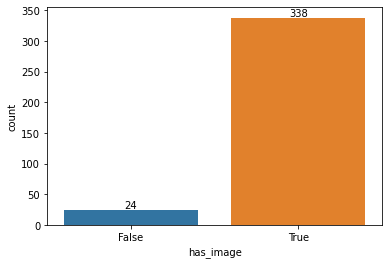

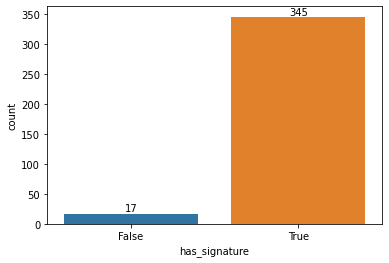

In [ ]:
# Visualize number of websites with images/signatures
import matplotlib.pyplot as plt
import seaborn as sns
ax = sns.countplot(x='has_image', data=data)
ax.bar_label(ax.containers[0])
plt.show()
ax = sns.countplot(x='has_signature', data=data)
ax.bar_label(ax.containers[0])
plt.show()

In [ ]:
data.to_csv('data_eileen.csv')

## Tracy: name & num_of_languages Preprocessing
- name: nothing to preprocess?

In [ ]:
import pandas as pd

data_eileen = pd.read_csv('data_eileen.csv')
data_eileen.head()

,Unnamed: 0,image_url,nama_penuh,name,num_of_languages,pekerjaan,pendidikan,signature_url,tempat_lahir,has_image,has_signature
0,1,https://ms.wikipedia.org/wiki/Fail:Aleksey_Leo...,NaN,Alexei Leonov,73 bahasa,Tentera Udara Soviet,Kesatuan Soviet,https://ms.wikipedia.org/wiki/Fail:Alexey_Leon...,Listvyanka,True,True
1,2,https://ms.wikipedia.org/wiki/Fail:Alan_Turing...,Alan Mathison Turing,Alan Turing,149 bahasa,NaN,Sherborne School,https://ms.wikipedia.org/wiki/Fail:Alan_Turing...,Maida Vale,True,True
2,3,https://ms.wikipedia.org/wiki/Fail:Albert_Camu...,NaN,Albert Camus,129 bahasa,NaN,Universiti Algiers,https://ms.wikipedia.org/wiki/Fail:Albert_Camu...,Dréan,True,True
3,4,https://ms.wikipedia.org/wiki/Fail:Adolfo_P%C3...,NaN,Adolfo Pérez Esquivel,51 bahasa,NaN,NaN,https://ms.wikipedia.org/wiki/Fail:Firma_p%C3%...,Buenos Aires,True,True
4,5,https://ms.wikipedia.org/wiki/Fail:Ebiet_In_Pe...,Abid Ghoffar Aboe Dja'far,Ebiet G. Ade,9 bahasa,Penyanyi,Penyanyi,https://ms.wikipedia.org/wiki/Fail:Signature_o...,Banjarnegara,True,True


In [ ]:
data_cleaned_urls=data_eileen.copy()
data_cleaned_urls.head()

,Unnamed: 0,image_url,nama_penuh,name,num_of_languages,pekerjaan,pendidikan,signature_url,tempat_lahir,has_image,has_signature
0,1,https://ms.wikipedia.org/wiki/Fail:Aleksey_Leo...,NaN,Alexei Leonov,73 bahasa,Tentera Udara Soviet,Kesatuan Soviet,https://ms.wikipedia.org/wiki/Fail:Alexey_Leon...,Listvyanka,True,True
1,2,https://ms.wikipedia.org/wiki/Fail:Alan_Turing...,Alan Mathison Turing,Alan Turing,149 bahasa,NaN,Sherborne School,https://ms.wikipedia.org/wiki/Fail:Alan_Turing...,Maida Vale,True,True
2,3,https://ms.wikipedia.org/wiki/Fail:Albert_Camu...,NaN,Albert Camus,129 bahasa,NaN,Universiti Algiers,https://ms.wikipedia.org/wiki/Fail:Albert_Camu...,Dréan,True,True
3,4,https://ms.wikipedia.org/wiki/Fail:Adolfo_P%C3...,NaN,Adolfo Pérez Esquivel,51 bahasa,NaN,NaN,https://ms.wikipedia.org/wiki/Fail:Firma_p%C3%...,Buenos Aires,True,True
4,5,https://ms.wikipedia.org/wiki/Fail:Ebiet_In_Pe...,Abid Ghoffar Aboe Dja'far,Ebiet G. Ade,9 bahasa,Penyanyi,Penyanyi,https://ms.wikipedia.org/wiki/Fail:Signature_o...,Banjarnegara,True,True


Rename 'num_of_languages' from Eileen's to 'num_of_languages_original' for visualization later

In [ ]:
data_eileen.rename(columns = {'num_of_languages':'num_of_languages_original'}, inplace = True)
data_eileen.head()

,Unnamed: 0,image_url,nama_penuh,name,num_of_languages_original,pekerjaan,pendidikan,signature_url,tempat_lahir,has_image,has_signature
0,1,https://ms.wikipedia.org/wiki/Fail:Aleksey_Leo...,NaN,Alexei Leonov,73 bahasa,Tentera Udara Soviet,Kesatuan Soviet,https://ms.wikipedia.org/wiki/Fail:Alexey_Leon...,Listvyanka,True,True
1,2,https://ms.wikipedia.org/wiki/Fail:Alan_Turing...,Alan Mathison Turing,Alan Turing,149 bahasa,NaN,Sherborne School,https://ms.wikipedia.org/wiki/Fail:Alan_Turing...,Maida Vale,True,True
2,3,https://ms.wikipedia.org/wiki/Fail:Albert_Camu...,NaN,Albert Camus,129 bahasa,NaN,Universiti Algiers,https://ms.wikipedia.org/wiki/Fail:Albert_Camu...,Dréan,True,True
3,4,https://ms.wikipedia.org/wiki/Fail:Adolfo_P%C3...,NaN,Adolfo Pérez Esquivel,51 bahasa,NaN,NaN,https://ms.wikipedia.org/wiki/Fail:Firma_p%C3%...,Buenos Aires,True,True
4,5,https://ms.wikipedia.org/wiki/Fail:Ebiet_In_Pe...,Abid Ghoffar Aboe Dja'far,Ebiet G. Ade,9 bahasa,Penyanyi,Penyanyi,https://ms.wikipedia.org/wiki/Fail:Signature_o...,Banjarnegara,True,True


Drop unnecessary column

In [ ]:
data_cleaned_urls=data_cleaned_urls.drop(['Unnamed: 0'], axis=1)
data_cleaned_urls.head()

,image_url,nama_penuh,name,num_of_languages,pekerjaan,pendidikan,signature_url,tempat_lahir,has_image,has_signature
0,https://ms.wikipedia.org/wiki/Fail:Aleksey_Leo...,NaN,Alexei Leonov,73 bahasa,Tentera Udara Soviet,Kesatuan Soviet,https://ms.wikipedia.org/wiki/Fail:Alexey_Leon...,Listvyanka,True,True
1,https://ms.wikipedia.org/wiki/Fail:Alan_Turing...,Alan Mathison Turing,Alan Turing,149 bahasa,NaN,Sherborne School,https://ms.wikipedia.org/wiki/Fail:Alan_Turing...,Maida Vale,True,True
2,https://ms.wikipedia.org/wiki/Fail:Albert_Camu...,NaN,Albert Camus,129 bahasa,NaN,Universiti Algiers,https://ms.wikipedia.org/wiki/Fail:Albert_Camu...,Dréan,True,True
3,https://ms.wikipedia.org/wiki/Fail:Adolfo_P%C3...,NaN,Adolfo Pérez Esquivel,51 bahasa,NaN,NaN,https://ms.wikipedia.org/wiki/Fail:Firma_p%C3%...,Buenos Aires,True,True
4,https://ms.wikipedia.org/wiki/Fail:Ebiet_In_Pe...,Abid Ghoffar Aboe Dja'far,Ebiet G. Ade,9 bahasa,Penyanyi,Penyanyi,https://ms.wikipedia.org/wiki/Fail:Signature_o...,Banjarnegara,True,True


In [ ]:
data_cleaned_urls[['name', 'num_of_languages']].head()

,name,num_of_languages
0,Alexei Leonov,73 bahasa
1,Alan Turing,149 bahasa
2,Albert Camus,129 bahasa
3,Adolfo Pérez Esquivel,51 bahasa
4,Ebiet G. Ade,9 bahasa


Check for duplicate

In [ ]:
data_cleaned_urls[['name', 'num_of_languages']].duplicated().sum()

0

Check for null values

In [ ]:
data_cleaned_urls[['name', 'num_of_languages']].isnull().sum()

name                0
num_of_languages    0
dtype: int64

In [ ]:
data_cleaned_urls['num_of_languages'].value_counts()

41 bahasa     9
39 bahasa     9
60 bahasa     7
58 bahasa     7
84 bahasa     6
             ..
231 bahasa    1
164 bahasa    1
139 bahasa    1
2 bahasa      1
198 bahasa    1
Name: num_of_languages, Length: 144, dtype: int64

Replacing 'Add languages' from 'num_of_languages' column to 0
- Add languages usually means there's no other language available except BM

In [ ]:
data_cleaned_urls[data_cleaned_urls.num_of_languages=='Add languages']

,image_url,nama_penuh,name,num_of_languages,pekerjaan,pendidikan,signature_url,tempat_lahir,has_image,has_signature
74,https://ms.wikipedia.org/wiki/Fail:Jane_Campio...,Elizabeth Jane Campion,Jane Campion,Add languages,NaN,NaN,https://ms.wikipedia.org/wiki/Fail:Jane_Campio...,Wellington,True,True
82,https://ms.wikipedia.org/wiki/Fail:De_Soto_by_...,NaN,Hernando de Soto,Add languages,Penjelajah,Penjelajah,https://ms.wikipedia.org/wiki/Fail:Hernando_de...,Jerez de los Caballeros,True,True
193,NaN,Ali Azhar Damarrosydi,Ali Azhar D,Add languages,NaN,Indonesia,https://ms.wikipedia.org/wiki/Fail:Tanda_tanga...,Surabaya,False,True
237,https://ms.wikipedia.org/wiki/Fail:Aliando_Sya...,Muhammad Ali Syarief,Aliando,Add languages,NaN,NaN,https://ms.wikipedia.org/wiki/Fail:Aliando_(si...,Jakarta,True,True
332,NaN,NaN,Muhyiddin Yassin/Biografi,Add languages,NaN,Johari Abdul,https://ms.wikipedia.org/wiki/Fail:TSMY_sign.png,NaN,False,True


In [ ]:
data_cleaned_urls['num_of_languages'].replace(inplace=True,to_replace='Add languages',value=0)
data_cleaned_urls[data_cleaned_urls.num_of_languages=='Add languages']

,image_url,nama_penuh,name,num_of_languages,pekerjaan,pendidikan,signature_url,tempat_lahir,has_image,has_signature


Replacing 'satu bahasa' from 'num_of_languages' column to 1

In [ ]:
#replacing satu bahasa to 1

data_cleaned_urls['num_of_languages'].replace(inplace=True,to_replace='satu bahasa',value=1)
data_cleaned_urls[data_cleaned_urls.num_of_languages=='satu bahasa']

,image_url,nama_penuh,name,num_of_languages,pekerjaan,pendidikan,signature_url,tempat_lahir,has_image,has_signature


Removing 'bahasa' from 'num_of_languages' column

In [ ]:
#removing 'bahasa' in num_of_language column

data_cleaned_urls['num_of_languages'].replace(regex=True,inplace=True,to_replace='bahasa',value='')
data_cleaned_urls['num_of_languages'].str.strip()
data_cleaned_urls[['name', 'num_of_languages']].head()

,name,num_of_languages
0,Alexei Leonov,73
1,Alan Turing,149
2,Albert Camus,129
3,Adolfo Pérez Esquivel,51
4,Ebiet G. Ade,9


Removing NAN from 'num_of_languages' column
- If there's no other language, it should be 'Add language', shouldnt be NAN. Assuming these wikipedia biography doesnt exist

In [ ]:
temp = data_cleaned_urls[data_cleaned_urls['name'].isnull() | data_cleaned_urls['num_of_languages'].isnull()]
temp[['name','num_of_languages']]

,name,num_of_languages


In [ ]:
data_cleaned_urls.drop([81, 332], inplace=True)

In [ ]:
data_cleaned_urls[['name', 'num_of_languages']].isnull().sum()

name                0
num_of_languages    0
dtype: int64

Checking datatype
- Converting 'num_of_languages' object to int

In [ ]:
#checking datatype

data_cleaned_urls.dtypes

image_url           object
nama_penuh          object
name                object
num_of_languages    object
pekerjaan           object
pendidikan          object
signature_url       object
tempat_lahir        object
has_image             bool
has_signature         bool
dtype: object

In [ ]:
data_cleaned_urls['num_of_languages']=data_cleaned_urls['num_of_languages'].astype('int')
data_cleaned_urls.dtypes

image_url           object
nama_penuh          object
name                object
num_of_languages     int64
pekerjaan           object
pendidikan          object
signature_url       object
tempat_lahir        object
has_image             bool
has_signature         bool
dtype: object

Visualize
- num_of_languages

In [ ]:
numoflanguage_visualize=pd.DataFrame()
numoflanguage_visualize=data_cleaned_urls.merge(data_eileen[['num_of_languages_original', 'name']])
numoflanguage_visualize[['name', 'num_of_languages_original', 'num_of_languages']].head()

,name,num_of_languages_original,num_of_languages
0,Alexei Leonov,73 bahasa,73
1,Alan Turing,149 bahasa,149
2,Albert Camus,129 bahasa,129
3,Adolfo Pérez Esquivel,51 bahasa,51
4,Ebiet G. Ade,9 bahasa,9


In [ ]:
data_cleaned_urls.to_csv('liyanna.csv')

## Liyanna: pendidikan & pekerjaan 

In [ ]:
!pip3 install googletrans==3.1.0a0
from googletrans import Translator
translator = Translator()

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 55.1/55.1 KB 2.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.6/42.6 KB 4.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 133.4/133.4 KB 7.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.5/1.5 MB 32.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.6/53.6 KB 5.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 65.0/65.0 KB 7.1 MB/s eta 0:00:00
  Created wheel for googletrans: filename=googletrans-3.1.0a0-py3-none-any.whl size=16368 sha256=5e82c726c3c77597756f6f479e00f42655323729b3bdb693a32120b808ceed0d
  Stored in directory: /root/.cache/pip/wheels/dd/59/af/8d6c96a719763990f1c548e36b17d9efdfb767f42f7ff39f53
Successfully built googletrans
  Attempting uninstall: chardet
    Found existing installation: chardet 4.0.0
 

In [ ]:
import pandas as pd
df = pd.read_csv('data_tracy.csv')
old_pekerjaan_df = df[['pekerjaan']].copy() #for later visualization purpose
old_pendidikan_df = df[['pendidikan']].copy()
df.head()

,Unnamed: 0,image_url,nama_penuh,name,num_of_languages,pekerjaan,pendidikan,signature_url,tempat_lahir,has_image,has_signature
0,0,https://ms.wikipedia.org/wiki/Fail:Aleksey_Leo...,NaN,Alexei Leonov,73,Tentera Udara Soviet,Kesatuan Soviet,https://ms.wikipedia.org/wiki/Fail:Alexey_Leon...,Listvyanka,True,True
1,1,https://ms.wikipedia.org/wiki/Fail:Alan_Turing...,Alan Mathison Turing,Alan Turing,149,NaN,Sherborne School,https://ms.wikipedia.org/wiki/Fail:Alan_Turing...,Maida Vale,True,True
2,2,https://ms.wikipedia.org/wiki/Fail:Albert_Camu...,NaN,Albert Camus,129,NaN,Universiti Algiers,https://ms.wikipedia.org/wiki/Fail:Albert_Camu...,Dréan,True,True
3,3,https://ms.wikipedia.org/wiki/Fail:Adolfo_P%C3...,NaN,Adolfo Pérez Esquivel,51,NaN,NaN,https://ms.wikipedia.org/wiki/Fail:Firma_p%C3%...,Buenos Aires,True,True
4,4,https://ms.wikipedia.org/wiki/Fail:Ebiet_In_Pe...,Abid Ghoffar Aboe Dja'far,Ebiet G. Ade,9,Penyanyi,Penyanyi,https://ms.wikipedia.org/wiki/Fail:Signature_o...,Banjarnegara,True,True


In [ ]:
df['translated_value'] = df['pekerjaan'].apply(lambda x: translator.translate(x, dest='ms').text) #translate all english text to malay

In [ ]:
df['translated_value'] = df['translated_value'].replace("[,]+\s*", value = ', ', regex = True) #normalise the string "[a-zA-Z]+,[a-zA-Z]+" to "[a-zA-Z]+, [a-zA-Z]+"

In [ ]:
df['translated_value'] = df['translated_value'].str.lower() #convert to lowercase

In [ ]:
df['translated_value'] = df['translated_value'].str.strip(", ") #remove trailing and leading whitespaces and characters

In [ ]:
df['translated_value'] = df['translated_value'].replace('dalam', '', regex=True)

In [ ]:
df.rename(columns = {'translated_value':'translated_occupation'}, inplace = True) #change the column title

In [ ]:
df1 = df[['pendidikan']].copy() #to replace row that do not contain substring

In [ ]:
df2 = df[['pendidikan']].copy() #to keep row that contain substring

In [ ]:
df1 = df1[~df1["pendidikan"].str.contains('University|Universiti|College|Kolej|School|Sekolah', na=False)].replace('.', '', regex=True)
df1

,pendidikan
0,
3,NaN
4,
5,
6,
...,...
355,
356,
357,
358,NaN


In [ ]:
df2 = df2[df2['pendidikan'].str.contains('University|Universiti|College|Kolej|School|Sekolah', na=False)] #extract only the value contains with specific string
df2

,pendidikan
1,Sherborne School
2,Universiti Algiers
9,Universiti Princeton
22,Universiti Basel
26,School of Performing Arts Seoul
...,...
314,Tufts College
334,Yale University
336,Universiti Saint Petersburg
344,Konan University


In [ ]:
combined_df = pd.concat([df1, df2], axis=1) #concat 2 dataframe
combined_df

,pendidikan,pendidikan
0,,NaN
1,NaN,Sherborne School
2,NaN,Universiti Algiers
3,NaN,NaN
4,,NaN
...,...,...
355,,NaN
356,,NaN
357,,NaN
358,NaN,NaN


In [ ]:
combined_df = combined_df.iloc[: , 1:] #drop the first column as the second column keeps valid educational institution, total number of index is recovered as original indexnew_df
combined_df

,pendidikan
0,NaN
1,Sherborne School
2,Universiti Algiers
3,NaN
4,NaN
...,...
355,NaN
356,NaN
357,NaN
358,NaN


In [ ]:
df['pendidikan'] = combined_df['pendidikan'] #replace old value with new value
df['pekerjaan'] = df['translated_occupation'] #replace old value with new value
df

,Unnamed: 0,image_url,nama_penuh,name,num_of_languages,pekerjaan,pendidikan,signature_url,tempat_lahir,has_image,has_signature,translated_occupation
0,0,https://ms.wikipedia.org/wiki/Fail:Aleksey_Leo...,NaN,Alexei Leonov,73,tentera udara soviet,NaN,https://ms.wikipedia.org/wiki/Fail:Alexey_Leon...,Listvyanka,True,True,tentera udara soviet
1,1,https://ms.wikipedia.org/wiki/Fail:Alan_Turing...,Alan Mathison Turing,Alan Turing,149,,Sherborne School,https://ms.wikipedia.org/wiki/Fail:Alan_Turing...,Maida Vale,True,True,
2,2,https://ms.wikipedia.org/wiki/Fail:Albert_Camu...,NaN,Albert Camus,129,,Universiti Algiers,https://ms.wikipedia.org/wiki/Fail:Albert_Camu...,Dréan,True,True,
3,3,https://ms.wikipedia.org/wiki/Fail:Adolfo_P%C3...,NaN,Adolfo Pérez Esquivel,51,,NaN,https://ms.wikipedia.org/wiki/Fail:Firma_p%C3%...,Buenos Aires,True,True,
4,4,https://ms.wikipedia.org/wiki/Fail:Ebiet_In_Pe...,Abid Ghoffar Aboe Dja'far,Ebiet G. Ade,9,penyanyi,NaN,https://ms.wikipedia.org/wiki/Fail:Signature_o...,Banjarnegara,True,True,penyanyi
...,...,...,...,...,...,...,...,...,...,...,...,...
355,357,https://ms.wikipedia.org/wiki/Fail:Malcolm_X_N...,Malcolm Little,Malcolm X,94,,NaN,https://ms.wikipedia.org/wiki/Fail:Malcolm_X_S...,NaN,True,True,
356,358,https://ms.wikipedia.org/wiki/Fail:Mahathir_Mo...,NaN,Mahathir Mohamad,83,,NaN,NaN,NaN,True,False,
357,359,https://ms.wikipedia.org/wiki/Fail:Ferdinand_M...,Fernão de Magalhães,Ferdinand Magellan,161,,NaN,https://ms.wikipedia.org/wiki/Fail:Magellan_Si...,Sabrosa,True,True,
358,360,https://ms.wikipedia.org/wiki/Fail:Beethoven.jpg,NaN,Ludwig van Beethoven,198,,NaN,https://ms.wikipedia.org/wiki/Fail:Beethoven_S...,Bonn,True,True,


In [ ]:
df = df.drop(['translated_occupation'], axis=1)
df

,Unnamed: 0,image_url,nama_penuh,name,num_of_languages,pekerjaan,pendidikan,signature_url,tempat_lahir,has_image,has_signature
0,0,https://ms.wikipedia.org/wiki/Fail:Aleksey_Leo...,NaN,Alexei Leonov,73,tentera udara soviet,NaN,https://ms.wikipedia.org/wiki/Fail:Alexey_Leon...,Listvyanka,True,True
1,1,https://ms.wikipedia.org/wiki/Fail:Alan_Turing...,Alan Mathison Turing,Alan Turing,149,,Sherborne School,https://ms.wikipedia.org/wiki/Fail:Alan_Turing...,Maida Vale,True,True
2,2,https://ms.wikipedia.org/wiki/Fail:Albert_Camu...,NaN,Albert Camus,129,,Universiti Algiers,https://ms.wikipedia.org/wiki/Fail:Albert_Camu...,Dréan,True,True
3,3,https://ms.wikipedia.org/wiki/Fail:Adolfo_P%C3...,NaN,Adolfo Pérez Esquivel,51,,NaN,https://ms.wikipedia.org/wiki/Fail:Firma_p%C3%...,Buenos Aires,True,True
4,4,https://ms.wikipedia.org/wiki/Fail:Ebiet_In_Pe...,Abid Ghoffar Aboe Dja'far,Ebiet G. Ade,9,penyanyi,NaN,https://ms.wikipedia.org/wiki/Fail:Signature_o...,Banjarnegara,True,True
...,...,...,...,...,...,...,...,...,...,...,...
355,357,https://ms.wikipedia.org/wiki/Fail:Malcolm_X_N...,Malcolm Little,Malcolm X,94,,NaN,https://ms.wikipedia.org/wiki/Fail:Malcolm_X_S...,NaN,True,True
356,358,https://ms.wikipedia.org/wiki/Fail:Mahathir_Mo...,NaN,Mahathir Mohamad,83,,NaN,NaN,NaN,True,False
357,359,https://ms.wikipedia.org/wiki/Fail:Ferdinand_M...,Fernão de Magalhães,Ferdinand Magellan,161,,NaN,https://ms.wikipedia.org/wiki/Fail:Magellan_Si...,Sabrosa,True,True
358,360,https://ms.wikipedia.org/wiki/Fail:Beethoven.jpg,NaN,Ludwig van Beethoven,198,,NaN,https://ms.wikipedia.org/wiki/Fail:Beethoven_S...,Bonn,True,True


In [ ]:
df.to_csv('data_tracy.csv')

In [ ]:
new_pekerjaan_df = df[['pekerjaan']].copy()
new_pendidikan_df = df[['pendidikan']].copy()
new_pekerjaan_df.rename(columns = {'pekerjaan':'pekerjaan_new'}, inplace = True)
new_pendidikan_df.rename(columns = {'pendidikan':'pendidikan_new'}, inplace = True)

### **Visualization on 'pekerjaan' after transformation**

In [ ]:
pekerjaan_visualization = pd.concat([old_pekerjaan_df, new_pekerjaan_df], axis=1)
pekerjaan_visualization.head()

,pekerjaan,pekerjaan_new
0,Tentera Udara Soviet,tentera udara soviet
1,NaN,
2,NaN,
3,NaN,
4,Penyanyi,penyanyi


### **Visualization on 'pendidikan' after transformation**

In [ ]:
pendidikan_visualization = pd.concat([old_pendidikan_df, new_pendidikan_df], axis=1)
pendidikan_visualization.head()

,pendidikan,pendidikan_new
0,Kesatuan Soviet,NaN
1,Sherborne School,Sherborne School
2,Universiti Algiers,Universiti Algiers
3,NaN,NaN
4,Penyanyi,NaN


## Amira - nama_penuh & tempat_lahir

for tempat_lahir, there will be no changes.

In [ ]:
import pandas as pd
data_liyanna = pd.read_csv('liyanna.csv')
data_liyanna.head()

,Unnamed: 0,image_url,nama_penuh,name,num_of_languages,pekerjaan,pendidikan,signature_url,tempat_lahir,has_image,has_signature
0,0,https://ms.wikipedia.org/wiki/Fail:Aleksey_Leo...,NaN,Alexei Leonov,73,Tentera Udara Soviet,Kesatuan Soviet,https://ms.wikipedia.org/wiki/Fail:Alexey_Leon...,Listvyanka,True,True
1,1,https://ms.wikipedia.org/wiki/Fail:Alan_Turing...,Alan Mathison Turing,Alan Turing,149,NaN,Sherborne School,https://ms.wikipedia.org/wiki/Fail:Alan_Turing...,Maida Vale,True,True
2,2,https://ms.wikipedia.org/wiki/Fail:Albert_Camu...,NaN,Albert Camus,129,NaN,Universiti Algiers,https://ms.wikipedia.org/wiki/Fail:Albert_Camu...,Dréan,True,True
3,3,https://ms.wikipedia.org/wiki/Fail:Adolfo_P%C3...,NaN,Adolfo Pérez Esquivel,51,NaN,NaN,https://ms.wikipedia.org/wiki/Fail:Firma_p%C3%...,Buenos Aires,True,True
4,4,https://ms.wikipedia.org/wiki/Fail:Ebiet_In_Pe...,Abid Ghoffar Aboe Dja'far,Ebiet G. Ade,9,Penyanyi,Penyanyi,https://ms.wikipedia.org/wiki/Fail:Signature_o...,Banjarnegara,True,True


In [ ]:
# copy to be used as comparison before and after
fullname = data_liyanna.copy()
fullname.head()

,Unnamed: 0,image_url,nama_penuh,name,num_of_languages,pekerjaan,pendidikan,signature_url,tempat_lahir,has_image,has_signature
0,0,https://ms.wikipedia.org/wiki/Fail:Aleksey_Leo...,NaN,Alexei Leonov,73,Tentera Udara Soviet,Kesatuan Soviet,https://ms.wikipedia.org/wiki/Fail:Alexey_Leon...,Listvyanka,True,True
1,1,https://ms.wikipedia.org/wiki/Fail:Alan_Turing...,Alan Mathison Turing,Alan Turing,149,NaN,Sherborne School,https://ms.wikipedia.org/wiki/Fail:Alan_Turing...,Maida Vale,True,True
2,2,https://ms.wikipedia.org/wiki/Fail:Albert_Camu...,NaN,Albert Camus,129,NaN,Universiti Algiers,https://ms.wikipedia.org/wiki/Fail:Albert_Camu...,Dréan,True,True
3,3,https://ms.wikipedia.org/wiki/Fail:Adolfo_P%C3...,NaN,Adolfo Pérez Esquivel,51,NaN,NaN,https://ms.wikipedia.org/wiki/Fail:Firma_p%C3%...,Buenos Aires,True,True
4,4,https://ms.wikipedia.org/wiki/Fail:Ebiet_In_Pe...,Abid Ghoffar Aboe Dja'far,Ebiet G. Ade,9,Penyanyi,Penyanyi,https://ms.wikipedia.org/wiki/Fail:Signature_o...,Banjarnegara,True,True


In [ ]:
fullname.rename(columns = {'nama_penuh':'full_name'}, inplace=True)
fullname.head()

,Unnamed: 0,image_url,full_name,name,num_of_languages,pekerjaan,pendidikan,signature_url,tempat_lahir,has_image,has_signature
0,0,https://ms.wikipedia.org/wiki/Fail:Aleksey_Leo...,NaN,Alexei Leonov,73,Tentera Udara Soviet,Kesatuan Soviet,https://ms.wikipedia.org/wiki/Fail:Alexey_Leon...,Listvyanka,True,True
1,1,https://ms.wikipedia.org/wiki/Fail:Alan_Turing...,Alan Mathison Turing,Alan Turing,149,NaN,Sherborne School,https://ms.wikipedia.org/wiki/Fail:Alan_Turing...,Maida Vale,True,True
2,2,https://ms.wikipedia.org/wiki/Fail:Albert_Camu...,NaN,Albert Camus,129,NaN,Universiti Algiers,https://ms.wikipedia.org/wiki/Fail:Albert_Camu...,Dréan,True,True
3,3,https://ms.wikipedia.org/wiki/Fail:Adolfo_P%C3...,NaN,Adolfo Pérez Esquivel,51,NaN,NaN,https://ms.wikipedia.org/wiki/Fail:Firma_p%C3%...,Buenos Aires,True,True
4,4,https://ms.wikipedia.org/wiki/Fail:Ebiet_In_Pe...,Abid Ghoffar Aboe Dja'far,Ebiet G. Ade,9,Penyanyi,Penyanyi,https://ms.wikipedia.org/wiki/Fail:Signature_o...,Banjarnegara,True,True


In [ ]:
# drop unnecessary column
fullname = fullname.drop(['Unnamed: 0'], axis=1)
fullname.head()

,image_url,full_name,name,num_of_languages,pekerjaan,pendidikan,signature_url,tempat_lahir,has_image,has_signature
0,https://ms.wikipedia.org/wiki/Fail:Aleksey_Leo...,NaN,Alexei Leonov,73,Tentera Udara Soviet,Kesatuan Soviet,https://ms.wikipedia.org/wiki/Fail:Alexey_Leon...,Listvyanka,True,True
1,https://ms.wikipedia.org/wiki/Fail:Alan_Turing...,Alan Mathison Turing,Alan Turing,149,NaN,Sherborne School,https://ms.wikipedia.org/wiki/Fail:Alan_Turing...,Maida Vale,True,True
2,https://ms.wikipedia.org/wiki/Fail:Albert_Camu...,NaN,Albert Camus,129,NaN,Universiti Algiers,https://ms.wikipedia.org/wiki/Fail:Albert_Camu...,Dréan,True,True
3,https://ms.wikipedia.org/wiki/Fail:Adolfo_P%C3...,NaN,Adolfo Pérez Esquivel,51,NaN,NaN,https://ms.wikipedia.org/wiki/Fail:Firma_p%C3%...,Buenos Aires,True,True
4,https://ms.wikipedia.org/wiki/Fail:Ebiet_In_Pe...,Abid Ghoffar Aboe Dja'far,Ebiet G. Ade,9,Penyanyi,Penyanyi,https://ms.wikipedia.org/wiki/Fail:Signature_o...,Banjarnegara,True,True


In [ ]:
fullname[['name', 'full_name']].head()

,name,full_name
0,Alexei Leonov,NaN
1,Alan Turing,Alan Mathison Turing
2,Albert Camus,NaN
3,Adolfo Pérez Esquivel,NaN
4,Ebiet G. Ade,Abid Ghoffar Aboe Dja'far


In [ ]:
fullname[['name', 'full_name']].isnull().sum()

name           0
full_name    154
dtype: int64

In [ ]:
# removing Edyta Gorniak full name as it is in date
import numpy as np

fullname['full_name'].replace('14 November 1972', np.NaN)

0                            NaN
1           Alan Mathison Turing
2                            NaN
3                            NaN
4      Abid Ghoffar Aboe Dja'far
                 ...            
355               Malcolm Little
356                          NaN
357          Fernão de Magalhães
358                          NaN
359                          NaN
Name: full_name, Length: 360, dtype: object

In [ ]:
# copy 'name' row to 'full_name' row with a condition where full_name = NaN because assumed that all data that has no full name, the name is its full name

# select NaN entries
null = fullname['full_name'].isnull()

fullname.loc[null, ['full_name']] = fullname['name']
print(fullname)

                                             image_url  \
0    https://ms.wikipedia.org/wiki/Fail:Aleksey_Leo...   
1    https://ms.wikipedia.org/wiki/Fail:Alan_Turing...   
2    https://ms.wikipedia.org/wiki/Fail:Albert_Camu...   
3    https://ms.wikipedia.org/wiki/Fail:Adolfo_P%C3...   
4    https://ms.wikipedia.org/wiki/Fail:Ebiet_In_Pe...   
..                                                 ...   
355  https://ms.wikipedia.org/wiki/Fail:Malcolm_X_N...   
356  https://ms.wikipedia.org/wiki/Fail:Mahathir_Mo...   
357  https://ms.wikipedia.org/wiki/Fail:Ferdinand_M...   
358   https://ms.wikipedia.org/wiki/Fail:Beethoven.jpg   
359  https://ms.wikipedia.org/wiki/Fail:Mads_Johans...   

                     full_name                   name  num_of_languages  \
0                Alexei Leonov          Alexei Leonov                73   
1         Alan Mathison Turing            Alan Turing               149   
2                 Albert Camus           Albert Camus               129   
3  

In [ ]:
fullname[['name', 'full_name']]

,name,full_name
0,Alexei Leonov,Alexei Leonov
1,Alan Turing,Alan Mathison Turing
2,Albert Camus,Albert Camus
3,Adolfo Pérez Esquivel,Adolfo Pérez Esquivel
4,Ebiet G. Ade,Abid Ghoffar Aboe Dja'far
...,...,...
355,Malcolm X,Malcolm Little
356,Mahathir Mohamad,Mahathir Mohamad
357,Ferdinand Magellan,Fernão de Magalhães
358,Ludwig van Beethoven,Ludwig van Beethoven


In [ ]:
fullname.dtypes

image_url           object
full_name           object
name                object
num_of_languages     int64
pekerjaan           object
pendidikan          object
signature_url       object
tempat_lahir        object
has_image             bool
has_signature         bool
dtype: object

In [ ]:
fullname.to_csv('amira.csv')

## final data + export

In [ ]:
fullname

,image_url,full_name,name,num_of_languages,pekerjaan,pendidikan,signature_url,tempat_lahir,has_image,has_signature
0,https://ms.wikipedia.org/wiki/Fail:Aleksey_Leo...,Alexei Leonov,Alexei Leonov,73,Tentera Udara Soviet,Kesatuan Soviet,https://ms.wikipedia.org/wiki/Fail:Alexey_Leon...,Listvyanka,True,True
1,https://ms.wikipedia.org/wiki/Fail:Alan_Turing...,Alan Mathison Turing,Alan Turing,149,NaN,Sherborne School,https://ms.wikipedia.org/wiki/Fail:Alan_Turing...,Maida Vale,True,True
2,https://ms.wikipedia.org/wiki/Fail:Albert_Camu...,Albert Camus,Albert Camus,129,NaN,Universiti Algiers,https://ms.wikipedia.org/wiki/Fail:Albert_Camu...,Dréan,True,True
3,https://ms.wikipedia.org/wiki/Fail:Adolfo_P%C3...,Adolfo Pérez Esquivel,Adolfo Pérez Esquivel,51,NaN,NaN,https://ms.wikipedia.org/wiki/Fail:Firma_p%C3%...,Buenos Aires,True,True
4,https://ms.wikipedia.org/wiki/Fail:Ebiet_In_Pe...,Abid Ghoffar Aboe Dja'far,Ebiet G. Ade,9,Penyanyi,Penyanyi,https://ms.wikipedia.org/wiki/Fail:Signature_o...,Banjarnegara,True,True
...,...,...,...,...,...,...,...,...,...,...
355,https://ms.wikipedia.org/wiki/Fail:Malcolm_X_N...,Malcolm Little,Malcolm X,94,NaN,Ferncliff Cemetery,https://ms.wikipedia.org/wiki/Fail:Malcolm_X_S...,NaN,True,True
356,https://ms.wikipedia.org/wiki/Fail:Mahathir_Mo...,Mahathir Mohamad,Mahathir Mohamad,83,NaN,Sultan Muhammad V,NaN,NaN,True,False
357,https://ms.wikipedia.org/wiki/Fail:Ferdinand_M...,Fernão de Magalhães,Ferdinand Magellan,161,NaN,Portugis,https://ms.wikipedia.org/wiki/Fail:Magellan_Si...,Sabrosa,True,True
358,https://ms.wikipedia.org/wiki/Fail:Beethoven.jpg,Ludwig van Beethoven,Ludwig van Beethoven,198,NaN,NaN,https://ms.wikipedia.org/wiki/Fail:Beethoven_S...,Bonn,True,True


In [ ]:
fullname.to_csv('data_clean.csv')